In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
genes_df = pd.read_csv(
    "./gene_annot_data/hg19/geneAnnotationsExonUnions.bed",
    sep="\t",
    header=None,
    names = ["chr",
            "txStart",
            "txEnd",
            "geneName",
            "citationCount",
            "strand",
            "union_geneId", # "refseqId",
            "geneId",
            "geneType",
            "geneDesc",
            "cdsStart",
            "cdsEnd",
            "exonStarts",
            "exonEnds"]
)
genes_df.head()

### we'll be removing duplicated genes because they're likely unamppable and/or harder to deal with anyways ...
### there are of course expections, but will do it anyways:
geneId_grp = genes_df.groupby("geneId")
genes_df = geneId_grp.first()[geneId_grp.size() == 1].reset_index()

### Let's merge in Gene Expression level information into our gene annotation DataFrame 

In [5]:
rsem_df = pd.read_csv("merged_TPM_genes.tsv",sep="\t")[["Id","rsem.out.S442_NT"]]
# genes_Df  overlap   rsem
# ~4_300     ~23_200   ~2_500

In [6]:
genes_exp_df = pd.merge(
    rsem_df,
    genes_df,
    how = 'inner',
    left_on="Id",
    right_on="geneName"
)
genes_exp_df.head(3)

,Id,rsem.out.S442_NT,geneId,chr,txStart,txEnd,geneName,citationCount,strand,union_geneId,geneType,geneDesc,cdsStart,cdsEnd,exonStarts,exonEnds
0,C9orf152,0,401546,chr9,112961844,112970439,C9orf152,5,-,union_401546,protein-coding,chromosome 9 open reading frame 152,112963227,112969859,"112961844,112969666","112963754,112970439"
1,RPS11,4520,6205,chr19,49999690,50002965,RPS11,149,+,union_6205,protein-coding,ribosomal protein S11,49999713,50002892,"49999690,50000450,50000776,50001173,50002768","49999728,50000582,50000852,50001303,50002965"
2,ELMO2,14,63916,chr20,44994683,45035690,ELMO2,47,-,union_63916,protein-coding,engulfment and cell motility 2,44995998,45017838,"44994683,44994689,44997529,44999081,44999990,4...","44996199,44996199,44997607,44999164,45000098,4..."


In [7]:
# columns needed for TSS/TTS bed files output:
tx_cols = ["chr", "txStart", "txEnd", "strand", "rsem.out.S442_NT"]

tx_cols_rename = {"chr":"chrom",
                  "txStart":"start",
                  "txEnd":"end",
                  "rsem.out.S442_NT":"exp"}

gdf =  genes_exp_df[tx_cols].reset_index(drop=True).rename(tx_cols_rename,axis=1)

gdf["size"] = gdf["end"] - gdf["start"]

In [8]:
gdf = gdf.sort_values(["chrom","start"])
gdf = gdf[gdf["chrom"].isin(autosomal_chroms)]
gdf = gdf.reset_index(drop=True)
gdf.head(3)

,chrom,start,end,strand,exp,size
0,chr1,11873,14409,+,0,2536
1,chr1,14361,29370,-,32,15009
2,chr1,69090,70008,+,0,918


In [9]:
fig5_samples = ["ins_CTCF",
                "ins_noCTCF",
                "ins_polII",
                "ins_nopolII",
                "ev1_CTCF",
                "ev1_noCTCF",
                "ev1_polII",
                "ev1_nopolII",
                "polII",
                'h3k4_r1',
                "mrna_ctcf",
                "mrna_noctcf"]

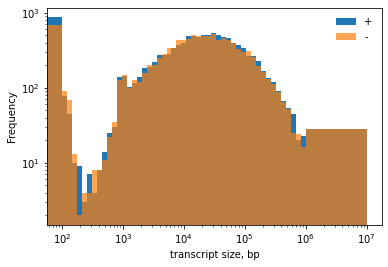

In [10]:
bins = np.r_[0,np.geomspace(100,1_000_000),10_000_000]
gdf[gdf["strand"]=="+"]["size"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["size"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("transcript size, bp")
ax.legend(frameon=False)

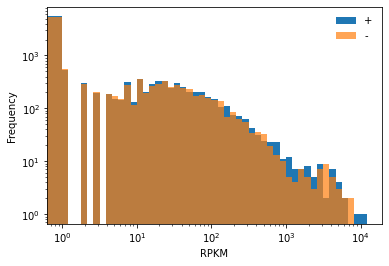

In [11]:
# actually - negative polarity genes are less expressed than tha positive strand genes ...
bins = np.r_[0,np.geomspace(1,12000)]
gdf[gdf["strand"]=="+"]["exp"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["exp"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("RPKM")
ax.legend(frameon=False)

In [25]:
exp_bin_edges = [0,1,10,np.inf]
exp_labels = ("no","low","high")
sizes_bin_edges = [0,50_000,np.inf]
sizes_labels = ("short","long")

gdf["gexp"] = pd.cut(
    gdf["exp"],
    bins = exp_bin_edges,
    labels = exp_labels,
    include_lowest = True
)
gdf["gsize"] = pd.cut(
    gdf["size"],
    bins = sizes_bin_edges,
    labels = sizes_labels,
    include_lowest = True
)
display(gdf.head())
display( gdf.groupby(["gexp","gsize"]).size().unstack(fill_value=0) )

,chrom,start,end,strand,exp,size,gexp,gsize
0,chr1,9337,16945,+,0,2536,no,short
1,chr1,-648,44379,-,32,15009,high,short
2,chr1,68172,70926,+,0,918,no,short
3,chr1,128978,146360,-,0,5794,no,short
4,chr1,561129,566019,-,0,1630,no,short


gsize,short,long
gexp,,
no,9492,2418
low,1842,1227
high,5035,2280


In [13]:
# extend the stacking region by the gene length on each side !
gdf["start"] = gdf["start"] - gdf["size"]
gdf["end"] = gdf["end"] + gdf["size"]

In [16]:
# 'ev1_CTCF', 'ev1_noCTCF', 'ev1_polII', 'ev1_nopolII'
def extract_ins(df,
                fname,
                bins=3000
               ):
    """
    for a BED-like DF, extract 'signal' from BW (fname) for every interval
    use "strand" information to flip "-" strand genes ...
    """
    return np.nanmean(np.asarray([
        bbi.fetch
               (
                    fname,
                    chrom,
                    start,
                    end,
                    bins=bins,
                    missing=0.0,
                    oob=np.nan,
                    summary='mean',
                )[:: (1 if strand=="+" else -1) ] # flip in place for "-" genes
      for chrom, start, end, strand, *_ in df.itertuples(index=False)
    ]),
      axis=0,                
     )


def extract_ins_noflip(df,
                fname,
                bins=3000
               ):
    """
    for a BED-like DF, extract 'signal' from BW (fname) for every interval
    no flipping ...
    """
    return np.nanmean(np.asarray([
        bbi.fetch
               (
                    fname,
                    chrom,
                    start,
                    end,
                    bins=bins,
                    missing=0.0,
                    oob=np.nan,
                    summary='mean',
                )
      for chrom, start, end, *_ in df.itertuples(index=False)
    ]),
      axis=0,                
     )


In [17]:
samples.keys()

dict_keys(['ctcf', 'noctcf', 'rad21_CTCF', 'rad21_noCTCF', 'rad21_wt1', 'rad21_rad21', 'rad21_norad21', 'G4a_r2', 'Rloop_K562', 'ddx_CTCF', 'ddx_noCTCF', 'taf5l_CTCF', 'taf5l_noCTCF', 'ddx_CTCF_r2', 'ddx_noCTCF_r2', 'taf5l_CTCF_r2', 'taf5l_noCTCF_r2', 'rad21_CTCF_r2', 'rad21_noCTCF_r2', 'input_CTCF_r2', 'input_noCTCF_r2', 'input_CTCF_r3', 'input_noCTCF_r3', 'input_CTCF', 'input_noCTCF', 'polII', 'h3k4_r1', 'h3k4_r2', 'h3k4_input', 'h3k4_k562', 'ins_CTCF', 'ins_noCTCF', 'ins_polII', 'ins_nopolII', 'ins_rad21', 'ins_norad21', 'ins_mutCtr_CTCF', 'ins_mutCtr_noCTCF', 'ins_mutDDX_CTCF', 'ins_mutDDX_noCTCF', 'ins_mutTAF_CTCF', 'ins_mutTAF_noCTCF', 'ins_siCtr_CTCF', 'ins_siCtr_noCTCF', 'ins_siDDX_CTCF', 'ins_siDDX_noCTCF', 'ins_siTAF_CTCF', 'ins_siTAF_noCTCF', 'ev1_CTCF', 'ev1_noCTCF', 'ev1_polII', 'ev1_nopolII', 'ev1_rad21', 'ev1_norad21', 'ev1_mutCtr_CTCF', 'ev1_mutCtr_noCTCF', 'ev1_mutDDX_CTCF', 'ev1_mutDDX_noCTCF', 'ev1_mutTAF_CTCF', 'ev1_mutTAF_noCTCF', 'ev1_siCtr_CTCF', 'ev1_siCtr_noCTC

In [26]:
ctcf_df = bioframe.read_table("intersect-all-NT-CTCF-NO-G4-centered-RAD21",schema="bed3",index_col=False)
# # ctcf_df = pd.read_table("intersect-all-NT-CTCF-NO-G4-centered-RAD21",header=None)
ctcf_df = ctcf_df.sort_values(["chrom","start"])
ctcf_df = ctcf_df[ctcf_df["chrom"].isin(autosomal_chroms)]
ctcf_df = ctcf_df.reset_index(drop=True)
ctcf_df["start"] = ctcf_df["start"] - 200_000
ctcf_df["end"] = ctcf_df["end"] + 200_000
ctcf_df.head(3)

,chrom,start,end
0,chr1,-189849,210508
1,chr1,604937,1005691
2,chr1,675596,1075897


### CTCF insulation/Rloops profiles to match the scaled TSS/TTS profiles ...

In [19]:
feature_name = "ins_CTCF"
feature_fname = samples[feature_name]["fname"]
ins_CTCF_CTCFprofiles = extract_ins_noflip(ctcf_df, feature_fname, bins=300)

feature_name = "ins_noCTCF"
feature_fname = samples[feature_name]["fname"]
ins_noCTCF_CTCFprofiles = extract_ins_noflip(ctcf_df, feature_fname, bins=300)

feature_name = "ins_polII"
feature_fname = samples[feature_name]["fname"]
ins_polII_CTCFprofiles = extract_ins_noflip(ctcf_df, feature_fname, bins=300)

feature_name = "ins_nopolII"
feature_fname = samples[feature_name]["fname"]
ins_nopolII_CTCFprofiles = extract_ins_noflip(ctcf_df, feature_fname, bins=300)

feature_name = "Rloop_K562"
feature_fname = samples[feature_name]["fname"]
rloop_CTCFprofiles = extract_ins_noflip(ctcf_df, feature_fname, bins=300)

feature_name = "G4a_r2"
feature_fname = samples[feature_name]["fname"]
g4_CTCFprofiles = extract_ins_noflip(ctcf_df, feature_fname, bins=300)



In [38]:
feature_name = "G4a_r2"
feature_fname = samples[feature_name]["fname"]
g4_CTCFprofiles = extract_ins_noflip(ctcf_df, feature_fname, bins=300)


### TSS to TTS scaled profiles ...

In [27]:
feature_name = "ins_CTCF"
feature_fname = samples[feature_name]["fname"]
ins_CTCF_profiles = gdf.groupby(["gexp","gsize"]).apply( lambda sub_df: extract_ins(sub_df, feature_fname) )

feature_name = "ins_noCTCF"
feature_fname = samples[feature_name]["fname"]
ins_noCTCF_profiles = gdf.groupby(["gexp","gsize"]).apply( lambda sub_df: extract_ins(sub_df, feature_fname) )

feature_name = "ins_polII"
feature_fname = samples[feature_name]["fname"]
ins_polII_profiles = gdf.groupby(["gexp","gsize"]).apply( lambda sub_df: extract_ins(sub_df, feature_fname) )

feature_name = "ins_nopolII"
feature_fname = samples[feature_name]["fname"]
ins_nopolII_profiles = gdf.groupby(["gexp","gsize"]).apply( lambda sub_df: extract_ins(sub_df, feature_fname) )

feature_name = "Rloop_K562"
feature_fname = samples[feature_name]["fname"]
rloop_profiles = gdf.groupby(["gexp","gsize"]).apply( lambda sub_df: extract_ins(sub_df, feature_fname) )

feature_name = "G4a_r2"
feature_fname = samples[feature_name]["fname"]
g4_profiles = gdf.groupby(["gexp","gsize"]).apply( lambda sub_df: extract_ins(sub_df, feature_fname) )


In [39]:

feature_name = "G4a_r2"
feature_fname = samples[feature_name]["fname"]
g4_profiles = gdf.groupby(["gexp","gsize"]).apply( lambda sub_df: extract_ins(sub_df, feature_fname) )


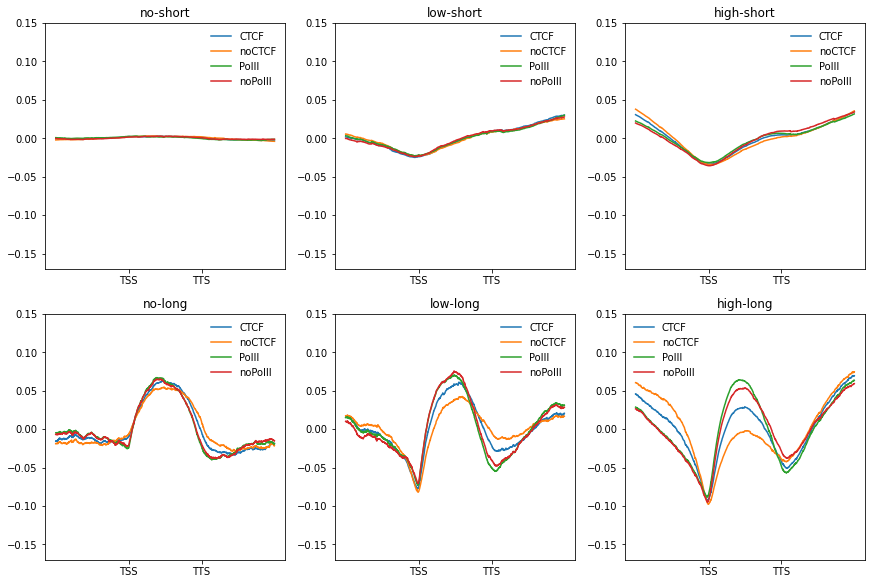

In [28]:
# xxx.to_dict().keys()
glens=("short","long")
gexps=("no","low","high")

fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(len(glens),len(gexps))

for i,glen in enumerate(glens):
    for j,gexp in enumerate(gexps):
        ax = fig.add_subplot(gs[i,j])
        ax.plot(ins_CTCF_profiles[(gexp,glen)] - np.nanmean(ins_CTCF_profiles[(gexp,glen)]),label="CTCF")
        ax.plot(ins_noCTCF_profiles[(gexp,glen)] - np.nanmean(ins_noCTCF_profiles[(gexp,glen)]),label="noCTCF")
        ax.plot(ins_polII_profiles[(gexp,glen)] - np.nanmean(ins_polII_profiles[(gexp,glen)]),label="PolII")
        ax.plot(ins_nopolII_profiles[(gexp,glen)] - np.nanmean(ins_nopolII_profiles[(gexp,glen)]),label="noPolII")
        ax.set_title(f"{gexp}-{glen}")
        ax.legend(frameon=False)
        ax.set_ylim(-0.17,.15)
#         ax.set_ylim(0,500)
        ax.set_xticks([1000,2000])
        ax.set_xticklabels(["TSS","TTS"])

### Figure 3C itself ! comparing average insulation


[Text(1000, 0, 'TSS'), Text(2000, 0, 'TTS')]

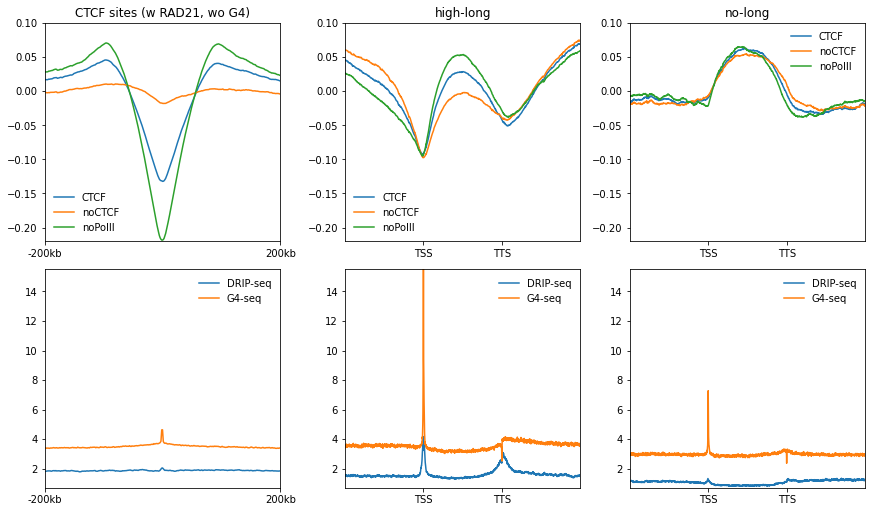

In [43]:
fig = plt.figure(figsize=(12,7),constrained_layout=True)
gs = fig.add_gridspec(2,3)



ax = fig.add_subplot(gs[0,0])
ax.plot(ins_CTCF_CTCFprofiles - np.nanmean(ins_CTCF_CTCFprofiles),label="CTCF")
ax.plot(ins_noCTCF_CTCFprofiles - np.nanmean(ins_noCTCF_CTCFprofiles),label="noCTCF")
ax.plot(ins_nopolII_CTCFprofiles - np.nanmean(ins_nopolII_CTCFprofiles),label="noPolII")
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(-0.22,.1)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])

ax = fig.add_subplot(gs[1,0])
ax.plot(rloop_CTCFprofiles,label="DRIP-seq")
ax.plot(g4_CTCFprofiles,label="G4-seq")
# ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(0.7,15.5)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])



gexp,glen = "high","long"
ax = fig.add_subplot(gs[0,1])
ax.plot(ins_CTCF_profiles[(gexp,glen)] - np.nanmean(ins_CTCF_profiles[(gexp,glen)]),label="CTCF")
ax.plot(ins_noCTCF_profiles[(gexp,glen)] - np.nanmean(ins_noCTCF_profiles[(gexp,glen)]),label="noCTCF")
ax.plot(ins_nopolII_profiles[(gexp,glen)] - np.nanmean(ins_nopolII_profiles[(gexp,glen)]),label="noPolII")
ax.set_title(f"{gexp}-{glen}")
ax.legend(frameon=False)
ax.set_ylim(-0.22,.1)
#         ax.set_ylim(0,500)
ax.set_xlim([0,3000])
ax.set_xticks([1000,2000])
ax.set_xticklabels(["TSS","TTS"])

gexp,glen = "no","long"
ax = fig.add_subplot(gs[0,2])
ax.plot(ins_CTCF_profiles[(gexp,glen)] - np.nanmean(ins_CTCF_profiles[(gexp,glen)]),label="CTCF")
ax.plot(ins_noCTCF_profiles[(gexp,glen)] - np.nanmean(ins_noCTCF_profiles[(gexp,glen)]),label="noCTCF")
ax.plot(ins_nopolII_profiles[(gexp,glen)] - np.nanmean(ins_nopolII_profiles[(gexp,glen)]),label="noPolII")
ax.set_title(f"{gexp}-{glen}")
ax.legend(frameon=False)
ax.set_ylim(-0.22,.1)
#         ax.set_ylim(0,500)
ax.set_xlim([0,3000])
ax.set_xticks([1000,2000])
ax.set_xticklabels(["TSS","TTS"])



gexp,glen = "high","long"
ax = fig.add_subplot(gs[1,1])
ax.plot(rloop_profiles[(gexp,glen)],label="DRIP-seq")
ax.plot(g4_profiles[(gexp,glen)],label="G4-seq")
ax.legend(frameon=False)
ax.set_ylim(.7,15.5)
ax.set_xlim([0,3000])
ax.set_xticks([1000,2000])
ax.set_xticklabels(["TSS","TTS"])

gexp,glen = "no","long"
ax = fig.add_subplot(gs[1,2])
ax.plot(rloop_profiles[(gexp,glen)],label="DRIP-seq")
ax.plot(g4_profiles[(gexp,glen)],label="G4-seq")
ax.legend(frameon=False)
ax.set_ylim(.7,15.5)
ax.set_xlim([0,3000])
ax.set_xticks([1000,2000])
ax.set_xticklabels(["TSS","TTS"])
# plt.savefig("Fig3C.pdf")

In [37]:
# ! scp Fig3C.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/